# Transfer Learning with keras pretrained model- Xception 
This model has weights that have been pretrained on imagenet
More layers are added on top of the model.
Could use data augmentation for better results- I did not try that yet
This still need to be fine-tuned for better performance

There are other pretrained models we can try if this doesnt seem like it is working

Another thing that could be done is geting all the mixed dog breed images to arrays

Here are some links 
https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/

https://github.com/booleanhunter/Deep-Learning-Projects/blob/master/Predict%20Dog%20Breeds/dog_app.ipynb


In [1]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# For Dog Breed Predictor
from scipy import ndimage, io, misc
from xml.dom import minidom
from matplotlib.pyplot import imshow        
import matplotlib.pyplot as plt  
import imageio
%matplotlib inline                          
from tqdm import tqdm
import pandas as pd
from keras.applications.xception import Xception, preprocess_input, decode_predictions


/Users/Stephanie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ModuleNotFoundError: No module named 'tqdm'

In [5]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# load data
X = np.load(open('Dog_images.npy','rb'))
Y = np.load(open('Dog_labels.npy','rb'))

pre_y = preprocessing.minmax_scale(Y, feature_range=(0,119))

y_cat = to_categorical(pre_y, num_classes=None)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20, random_state=seed)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [6]:
bottleneck_features = np.load('DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [7]:
def extract_Xception(tensor):
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

On top of the pretrained model a fully connected layer with 1024 neurons and some Dropout is added.

In [11]:
NUM_CLASSES = 120
# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
#Can try adding more layers
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [7]:
import datetime
from keras.callbacks ModelCheckpoint

# checkpoints: to save the best weights (only if accuracy improves)
#I am having issue with the data, 
# so I'm not sure if these work
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)



Can try fine tuning more layers
Can try using different optimizers

In [8]:
# #will freeze the first 116 layers and unfreeze the rest:
# for layer in model.layers[:116]:
#     layer.trainable = False
# for layer in model.layers[116:]:
#     layer.trainable = True

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#Can try different optimizers like adam
optimizer = RMSprop(lr=0.001, rho=0.9)

#load weights from file in local directory (saved at previous checkpoint)
# in example at https://machinelearningmastery.com/check-point-deep-learning-models-keras/
# they used binary_crossentropy, but this shouldn't affect results
model.load_weights("weights.best.hdf5")

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])


In [15]:
# train the model on the new data for a few epochs
BATCH_SIZE = 32
EPOCHS = 1

#Checkpoints still need to be added to model.fit call
model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=EPOCHS, batch_size=BATCH_SIZE)

                      
# hist = model.fit(X_train, y_train,
#                            #callbacks=[early_stopping, model_checkpoint],
#                            validation_data=(X_valid, y_valid),epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=callbacks_list)

Train on 8177 samples, validate on 2045 samples
Epoch 1/1


6496/8177 [======================>.......] - ETA: 35:06 - loss: 5.9030 - acc: 0.0000e+ - ETA: 31:40 - loss: 5.5416 - acc: 0.0156   - ETA: 30:30 - loss: 5.6237 - acc: 0.03 - ETA: 29:49 - loss: 5.5522 - acc: 0.03 - ETA: 30:57 - loss: 5.4758 - acc: 0.03 - ETA: 30:53 - loss: 5.3457 - acc: 0.04 - ETA: 30:41 - loss: 5.2795 - acc: 0.04 - ETA: 30:46 - loss: 5.2356 - acc: 0.04 - ETA: 30:23 - loss: 5.1389 - acc: 0.06 - ETA: 30:11 - loss: 5.0303 - acc: 0.07 - ETA: 29:52 - loss: 4.9899 - acc: 0.07 - ETA: 29:34 - loss: 4.9598 - acc: 0.08 - ETA: 29:26 - loss: 4.9004 - acc: 0.08 - ETA: 29:38 - loss: 4.8317 - acc: 0.08 - ETA: 29:33 - loss: 4.7738 - acc: 0.09 - ETA: 29:25 - loss: 4.6969 - acc: 0.11 - ETA: 29:09 - loss: 4.6915 - acc: 0.10 - ETA: 28:57 - loss: 4.6966 - acc: 0.11 - ETA: 28:42 - loss: 4.6680 - acc: 0.11 - ETA: 28:28 - loss: 4.6335 - acc: 0.12 - ETA: 28:19 - loss: 4.5755 - acc: 0.13 - ETA: 28:06 - loss: 4.5246 - acc: 0.14 - ETA: 27:54 - loss: 4.4867 - acc: 0.14 - ETA: 27:48 - loss: 4.4545 -

In [ ]:
bst_val_acc = max(history['val_acc'])
print("Best val acc: {:.1%}".format(bst_val_acc))

In [ ]:
#checkpoint, load in best weights
filename = "weights.best.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rotation_range=45,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.25,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# test_datagen = ImageDataGenerator()

# Mixed Dog Breed Transfer Learning

In [ ]:
#Mixed dog breed data

In [ ]:
NUM_CLASSES = 120
# create the base pre-trained model
model = #best weight file here
x = model.output
#Can try adding more layers
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
Mixed_model = Model(inputs=model.input, outputs=predictions)



In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#Can try different optimizers like adam
optimizer = RMSprop(lr=0.001, rho=0.9)
Mixed_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])



In [ ]:
# train the model on the new data for a few epochs
BATCH_SIZE = 32
EPOCHS = 1

#Checkpoints still need to be added to model.fit call
Mixed_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=EPOCHS, batch_size=BATCH_SIZE)

                      
# hist = model.fit(X_train, y_train,
#                            #callbacks=[early_stopping, model_checkpoint],
#          

In [ ]:
bst_val_acc = max(history['val_acc'])
print("Best val acc: {:.1%}".format(bst_val_acc))

In [ ]:
#checkpoint: load in best weights
filename = "weights.best.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

scores = Mixed_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Dog Breed Predictor

In [17]:
#create a list of all 120 dog breeds

#read labels.csv 
data = pd.read_csv("labels.csv") 

pic_breed = data["breed"]

#get dog names
unique_Breed = pic_breed.unique()

In [18]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)


In [19]:
def display_image(img_path):
    a = imageio.imread(img_path)[:,:,:3]
    imshow(a)

In [20]:
def detect_dog(model, image_path):
    tensor = path_to_tensor(image_path)
    bottleneck_features = extract_Xception(tensor)
    predicted_vector = model.predict(tensor)
    return unique_Breed[np.argmax(predicted_vector)]

In [21]:
def dog_prediction(img_path):   
    display_image(img_path)
    prediction = detect_dog(model, img_path)
    print('What a cute... {} ! '.format(prediction))

What a cute... bernese_mountain_dog ! 


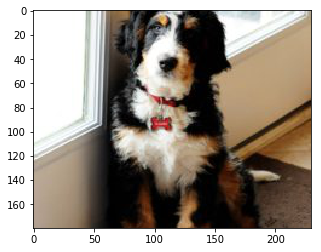

In [23]:
dog_prediction("test/n02940000_3.jpg")

What a cute... siberian_husky ! 


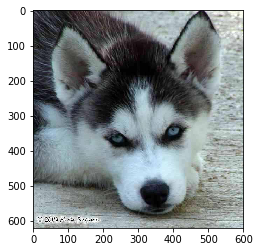

In [24]:
dog_prediction("test/15bf9b209d1e2a227028408b617822b2.jpg")

What a cute... komondor ! 


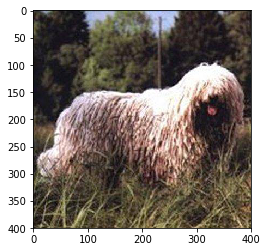

In [25]:
dog_prediction("test/79c961a446f41f6c090a2df5abab1c6b.jpg")